In [1]:
import os
os.chdir('../')

import warnings
warnings.filterwarnings('ignore')

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import os

!nvidia-smi
os.environ["CUDA_VISIBLE_DEVICES"]="2"

Fri Jan 19 01:12:13 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.223.02   Driver Version: 470.223.02   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100 80G...  Off  | 00000000:1B:00.0 Off |                    0 |
| N/A   48C    P0    71W / 300W |   8433MiB / 80994MiB |      9%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA A100 80G...  Off  | 00000000:1C:00.0 Off |                    0 |
| N/A   

### Model Parts

In [3]:
from model.main.enc_prior_latent_dec import Model
from model.encoder.conv2d_encoder import Encoder
from model.prior.randn_prior import Prior
from model.latent.lse_latent import Latent
from model.decoder.conv2d_decoder import Decoder

from tensorboardX import SummaryWriter
from util.util import *

### Model Init.

In [4]:
from easydict import EasyDict
hp = EasyDict()
hp.size = 64
hp.in_dim = 3
hp.out_dim = 3
hp.z_dim = 128
hp.h_dims = [32, 64, 128, 256, 512]
hp.M = 1024
hp.N = 256
hp.n_prior_embeddings = 256
hp.activation = F.sigmoid
hp.init_log_sigma = -4
hp.const_sigma = True

In [5]:
step = 0
device = 'cuda:0'

model_list = []
optimizer_list = []
for i in range(1):
    model = Model(Encoder(**hp), Prior(**hp), Latent(**hp), Decoder(**hp))
    model = model.to(device)
    model_list.append(model)
    
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
    optimizer_list.append(optimizer)

for name, module in model.named_modules():
    if len(name.split('.')) <= 2 and len(name) > 0:
        print(name, get_size(module))

print('done')

encoder 6.99169921875
encoder.convs 5.9912109375
encoder.linear 1.00048828125
prior 0.125
latent 3.814697265625e-06
decoder 7.028697967529297
decoder.linear 1.0078125
decoder.convs 5.9820556640625
decoder.out_conv 0.038829803466796875
done


### Load

In [6]:
save_dir = '/data/scpark/save/lse/train_celeba/train01.18-9/'

!mkdir -p $save_dir
!ls -lt $save_dir

writer = SummaryWriter(save_dir)

if False:
    step, models, opt_g = load(save_dir, 0, models, optimizer)

total 43888
-rw-rw-r-- 1 scpark scpark   298724  1월 19 01:12 events.out.tfevents.1705593467.GPUSVR11
-rw-rw-r-- 1 scpark scpark 44307191  1월 19 00:58 save_0
-rw-rw-r-- 1 scpark scpark   104132  1월 19 00:57 events.out.tfevents.1705593136.GPUSVR11
-rw-rw-r-- 1 scpark scpark   208964  1월 19 00:52 events.out.tfevents.1705592514.GPUSVR11


### Dataset

In [7]:
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import CelebA

class MyCelebA(CelebA):
    """
    A work-around to address issues with pytorch's celebA dataset class.
    
    Download and Extract
    URL : https://drive.google.com/file/d/1m8-EBPgi5MRubrm6iQjafK2QMHDBMSfJ/view?usp=sharing
    """
    
    def _check_integrity(self) -> bool:
        return True

root = '/data'
train_transforms = transforms.Compose([transforms.RandomHorizontalFlip(),
                                       transforms.CenterCrop(148),
                                       transforms.Resize(hp.size),
                                       transforms.ToTensor(),])
train_dataset = MyCelebA(root, split='train', transform=train_transforms, download=False)
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)

test_transforms = transforms.Compose([transforms.CenterCrop(148),
                                      transforms.Resize(hp.size),
                                      transforms.ToTensor(),])
test_dataset = MyCelebA(root, split='test', transform=test_transforms, download=False)
test_loader = DataLoader(test_dataset, batch_size=2048, shuffle=False)
print('done')

done


### Preprocess

In [8]:
def preprocess(batch):
    x, t = batch
    data = {}
    data['x'] = x.to(device)
    data['t'] = t.to(device)
    return data

### Train

In [9]:
def plot(x):
    _x = x.permute(0, 2, 3, 1).data.cpu().numpy()
    plt.figure(figsize=[18, 4])
    for i in range(10):
        plt.subplot(1, 10, i+1)
        plt.imshow(_x[i])
        plt.xticks([])
        plt.yticks([])
    plt.show()

tensor([0.0183], device='cuda:0')


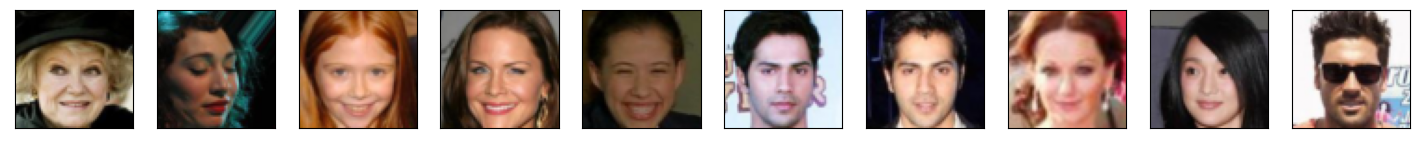

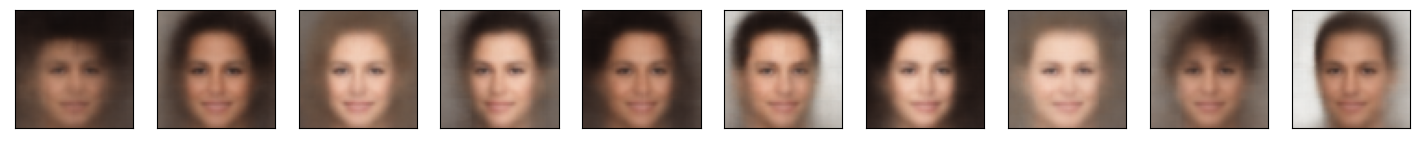

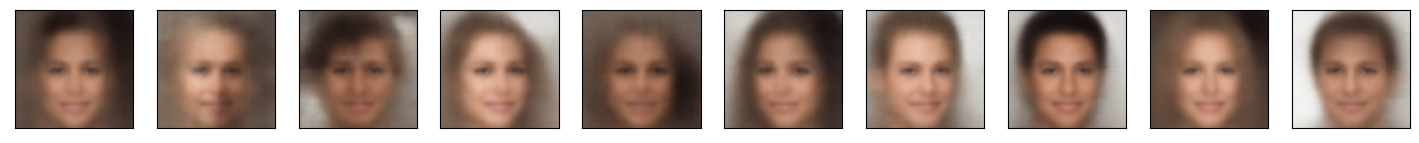

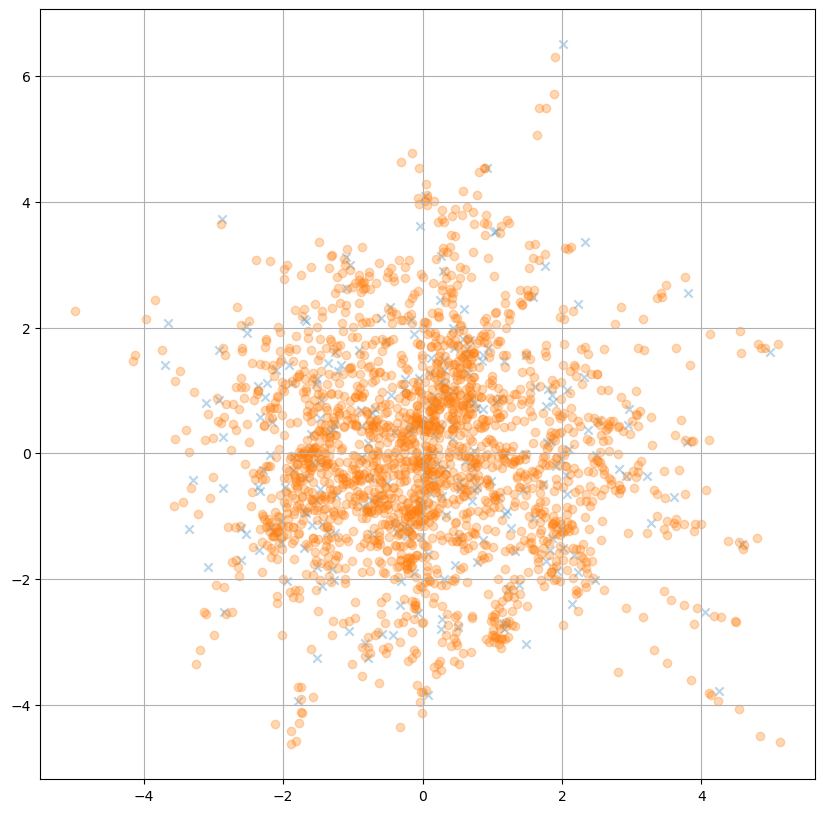

26001
lse_loss 72566.21875
recon_loss 0.035372354090213776
26002
lse_loss 68126.6875
recon_loss 0.03718721121549606
26003
lse_loss 73731.375
recon_loss 0.03620370849967003
26004
lse_loss 74711.6015625
recon_loss 0.035047244280576706
26005
lse_loss 72942.546875
recon_loss 0.03543657809495926
26006
lse_loss 74569.7109375
recon_loss 0.03672923147678375
26007
lse_loss 76287.09375
recon_loss 0.03727533668279648
26008
lse_loss 76209.7109375
recon_loss 0.03566616401076317
26009
lse_loss 72441.75
recon_loss 0.03534644842147827
26010
lse_loss 78088.4140625
recon_loss 0.035949788987636566
26011
lse_loss 70030.0
recon_loss 0.035228144377470016
26012
lse_loss 76070.640625
recon_loss 0.03556564450263977
26013
lse_loss 69724.046875
recon_loss 0.03623366355895996
26014
lse_loss 69732.40625
recon_loss 0.0354197695851326
26015
lse_loss 71946.8515625
recon_loss 0.03698843717575073
26016
lse_loss 75593.1875
recon_loss 0.03728201612830162
26017
lse_loss 75616.140625
recon_loss 0.03672357648611069
26018
ls

26141
lse_loss 66294.578125
recon_loss 0.036531075835227966
26142
lse_loss 73720.625
recon_loss 0.03647490590810776
26143
lse_loss 73204.2265625
recon_loss 0.03672407567501068
26144
lse_loss 73716.6640625
recon_loss 0.03476596251130104
26145
lse_loss 70918.046875
recon_loss 0.035145726054906845
26146
lse_loss 72674.6640625
recon_loss 0.03634895011782646
26147
lse_loss 74505.78125
recon_loss 0.037411242723464966
26148
lse_loss 75274.0
recon_loss 0.03478886932134628
26149
lse_loss 75251.1328125
recon_loss 0.03821634501218796
26150
lse_loss 70330.015625
recon_loss 0.03708815947175026
26151
lse_loss 76493.546875
recon_loss 0.038892537355422974
26152
lse_loss 76976.1171875
recon_loss 0.03730323538184166
26153
lse_loss 76238.859375
recon_loss 0.03742855042219162
26154
lse_loss 68365.875
recon_loss 0.03673131391406059
26155
lse_loss 75302.328125
recon_loss 0.037621475756168365
26156
lse_loss 78707.296875
recon_loss 0.03719698265194893
26157
lse_loss 73815.515625
recon_loss 0.03527245670557022

26281
lse_loss 75724.53125
recon_loss 0.03633309528231621
26282
lse_loss 69628.875
recon_loss 0.03466218337416649
26283
lse_loss 74581.125
recon_loss 0.03605671226978302
26284
lse_loss 73414.8515625
recon_loss 0.03737954422831535
26285
lse_loss 71448.09375
recon_loss 0.035635314881801605
26286
lse_loss 72798.859375
recon_loss 0.03710177168250084
26287
lse_loss 70113.1171875
recon_loss 0.03710407391190529
26288
lse_loss 79243.90625
recon_loss 0.0366811566054821
26289
lse_loss 72951.3046875
recon_loss 0.036923810839653015
26290
lse_loss 71476.1171875
recon_loss 0.03568607196211815
26291
lse_loss 72535.4140625
recon_loss 0.03449258208274841
26292
lse_loss 74685.671875
recon_loss 0.0373656265437603
26293
lse_loss 75550.4375
recon_loss 0.03664855286478996
26294
lse_loss 75410.03125
recon_loss 0.037728141993284225
26295
lse_loss 72372.8125
recon_loss 0.03561360388994217
26296
lse_loss 75507.046875
recon_loss 0.03535023704171181
26297
lse_loss 78317.75
recon_loss 0.0360182523727417
26298
lse_

26421
lse_loss 70941.859375
recon_loss 0.03589659184217453
26422
lse_loss 68199.5625
recon_loss 0.03493364900350571
26423
lse_loss 70671.25
recon_loss 0.03724764660000801
26424
lse_loss 75606.671875
recon_loss 0.034415893256664276
26425
lse_loss 71032.3125
recon_loss 0.03785216808319092
26426
lse_loss 74373.5625
recon_loss 0.03416311740875244
26427
lse_loss 75400.265625
recon_loss 0.038324855268001556
26428
lse_loss 74968.0546875
recon_loss 0.03859446197748184
26429
lse_loss 73592.0625
recon_loss 0.038515523076057434
26430
lse_loss 76552.09375
recon_loss 0.037651464343070984
26431
lse_loss 70420.59375
recon_loss 0.03626178950071335
26432
lse_loss 70195.2265625
recon_loss 0.036352530121803284
26433
lse_loss 79295.65625
recon_loss 0.035820089280605316
26434
lse_loss 76820.3828125
recon_loss 0.03675738722085953
26435
lse_loss 73110.046875
recon_loss 0.03645778447389603
26436
lse_loss 72071.65625
recon_loss 0.03722882270812988
26437
lse_loss 76180.296875
recon_loss 0.035956840962171555
264

26561
lse_loss 70398.84375
recon_loss 0.03830921649932861
26562
lse_loss 79246.9140625
recon_loss 0.03721044957637787
26563
lse_loss 76251.15625
recon_loss 0.03616117686033249
26564
lse_loss 71258.953125
recon_loss 0.03679628670215607
26565
lse_loss 72220.7578125
recon_loss 0.036722779273986816
26566
lse_loss 71404.71875
recon_loss 0.035724617540836334
26567
lse_loss 78306.046875
recon_loss 0.036549825221300125
26568
lse_loss 75609.90625
recon_loss 0.03682864457368851
26569
lse_loss 69149.015625
recon_loss 0.037494026124477386
26570
lse_loss 76326.75
recon_loss 0.036228276789188385
26571
lse_loss 70259.140625
recon_loss 0.036597125232219696
26572
lse_loss 68470.71875
recon_loss 0.037852875888347626
26573
lse_loss 73280.203125
recon_loss 0.03767227381467819
26574
lse_loss 78052.3984375
recon_loss 0.03433282673358917
26575
lse_loss 71429.1328125
recon_loss 0.0369991771876812
26576
lse_loss 73989.171875
recon_loss 0.03794217109680176
26577
lse_loss 71835.09375
recon_loss 0.036960016936063

26701
lse_loss 82571.6484375
recon_loss 0.03681185096502304
26702
lse_loss 71220.3046875
recon_loss 0.0359213761985302
26703
lse_loss 73319.421875
recon_loss 0.0376337431371212
26704
lse_loss 73515.875
recon_loss 0.03622578829526901
26705
lse_loss 72690.7734375
recon_loss 0.03548422455787659
26706
lse_loss 75315.2890625
recon_loss 0.037689950317144394
26707
lse_loss 69352.5078125
recon_loss 0.037615999579429626
26708
lse_loss 70970.828125
recon_loss 0.03621158003807068
26709
lse_loss 75355.359375
recon_loss 0.03689549118280411
26710
lse_loss 72970.046875
recon_loss 0.039053045213222504
26711
lse_loss 74044.5078125
recon_loss 0.036207519471645355
26712
lse_loss 71855.90625
recon_loss 0.03535155951976776
26713
lse_loss 73109.0546875
recon_loss 0.03658479452133179
26714
lse_loss 71157.8046875
recon_loss 0.036934416741132736
26715
lse_loss 68889.40625
recon_loss 0.0361618846654892
26716
lse_loss 72709.9296875
recon_loss 0.03557930141687393
26717
lse_loss 73614.75
recon_loss 0.0352823622524

In [ ]:
from IPython import display

while True:
    for batch in train_loader:
        print(step)
        
        loss_dict = {}
        for model, optimizer in zip(model_list, optimizer_list):
            data = preprocess(batch)

            # Forward
            model.train()
            model.zero_grad()
            data = model(data, M=1024)

            # Backward
            loss = 0
            for key in data.keys():
                if 'kl_loss' in key:
                    loss = loss + data[key] * 0.00025
                    if key in loss_dict:
                        loss_dict[key].append(data[key].item())
                    else:
                        loss_dict[key] = [data[key].item()]
                elif 'loss' in key:
                    loss = loss + data[key]
                    if key in loss_dict:
                        loss_dict[key].append(data[key].item())
                    else:
                        loss_dict[key] = [data[key].item()]
                    
            loss.backward()
            optimizer.step()
        
        for key in loss_dict:
            writer.add_scalar(key, np.mean(loss_dict[key]), step)
            print(key, np.mean(loss_dict[key]))
        
        if step % 1000 == 0:
            import matplotlib.pyplot as plt
            display.clear_output()
            
            print(torch.exp(model.latent.log_sigma))
            
            batch = next(iter(test_loader))
            data = preprocess(batch)
            
            model = model_list[0]
            model.eval()
            with torch.no_grad():
                data = model(data, M=1024)
            
            plot(data['x'])
            plot(data['y'])
            
            with torch.no_grad():
                z = model.prior.sample().to(device)
                y = model.sample(z)
                plot(y)
                
            from sklearn.decomposition import PCA
            pca = PCA(n_components=2)
            e = model.prior.prior.data.cpu().numpy()
            pca.fit(e)
            e_pca = pca.transform(e)
            z_pca = pca.transform(data['z'].data.cpu().numpy())
            plt.figure(figsize=[10, 10])
            plt.scatter(e_pca[:, 0], e_pca[:, 1], marker='x', alpha=0.3)
            plt.scatter(z_pca[:, 0], z_pca[:, 1], marker='o', alpha=0.3)
            plt.grid()
            plt.show()    
                
        if step % 10000 == 0:
            save_model_list(save_dir, step, model_list, optimizer_list)
                
        step += 1
        

In [14]:
save_model_list(save_dir, step, model_list, optimizer_list)
print('done')

done


tensor([0.0183], device='cuda:0')


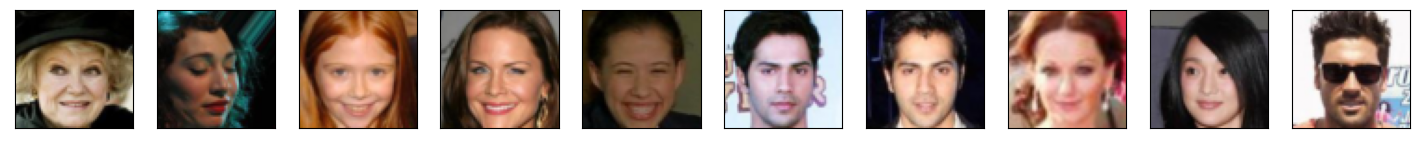

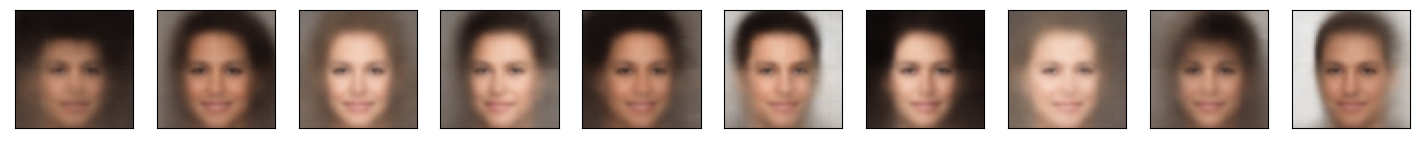

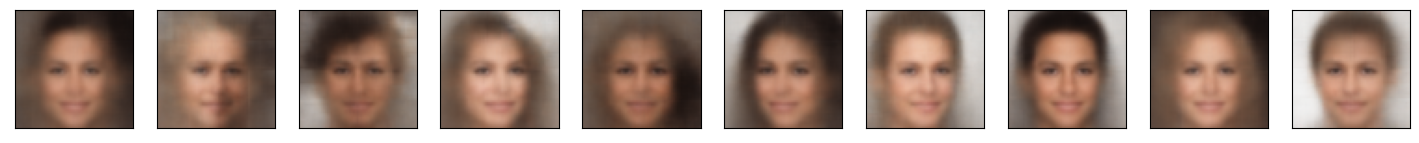

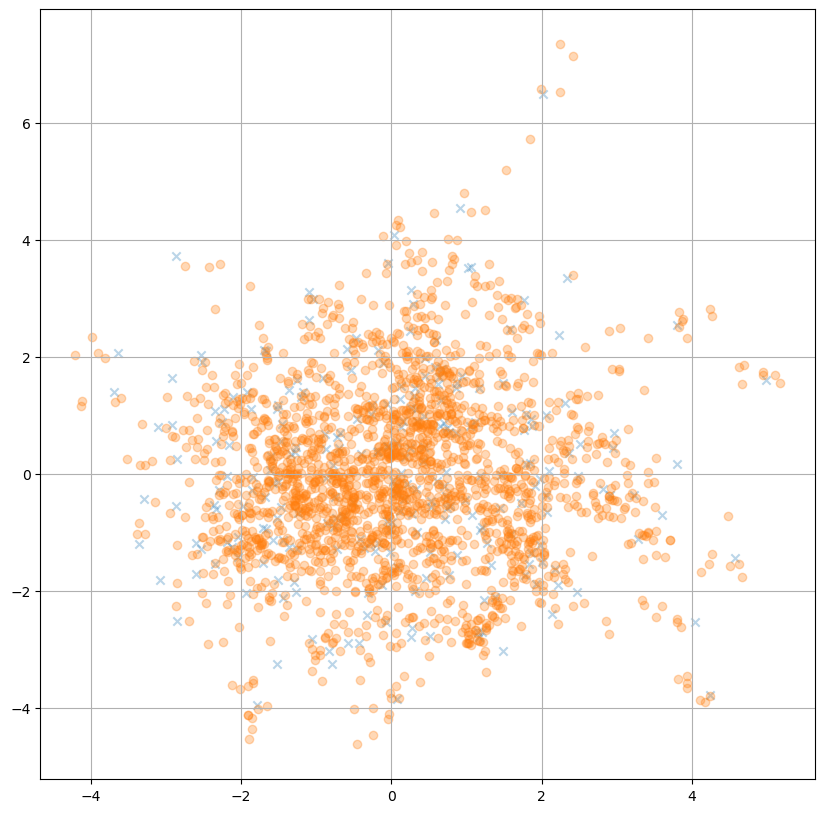

In [15]:
import matplotlib.pyplot as plt
display.clear_output()

print(torch.exp(model.latent.log_sigma))

batch = next(iter(test_loader))
data = preprocess(batch)

model = model_list[0]
model.eval()
with torch.no_grad():
    data = model(data, M=1024)

plot(data['x'])
plot(data['y'])

with torch.no_grad():
    z = model.prior.sample().to(device)
    y = model.sample(z)
    plot(y)

from sklearn.decomposition import PCA
pca = PCA(n_components=2)
e = model.prior.prior.data.cpu().numpy()
pca.fit(e)
e_pca = pca.transform(e)
z_pca = pca.transform(data['z'].data.cpu().numpy())
plt.figure(figsize=[10, 10])
plt.scatter(e_pca[:, 0], e_pca[:, 1], marker='x', alpha=0.3)
plt.scatter(z_pca[:, 0], z_pca[:, 1], marker='o', alpha=0.3)
plt.grid()
plt.show()    